## 第十周: 字詞分類
+ 課程目標
    + 用字詞向量的方式將不同的文集分類
+ 資料來源:
    + ptt 八卦版蒐集之文章
    + 時間:
    + 關鍵字:
    + 分類: 利用liwc字典計算情緒分數，分為正面、中性、負面三種標籤
+ 分析流程
    1. 文字前處理
        + 1.1 斷句
        + 1.2 前處理：斷詞（刪掉次數太少的、標點符號、停用字）
        + 1.3 算出情緒分數，將正負面文章分類
        + 1.4 將情緒標籤加回原本的資料集
    2. 將資料分為測試集和訓練集
        + 根據7:3的比例切分資料集
    3. 將文章轉為 DTM 放入模型訓練
        + 3.1 簡單範例介紹DTM
        + 3.2 套入正式資料集訓練
    4. 比較不同模型和資料組合的訓練結果
        + 4.1 logistic regression
        + 4.2 SVC
        + 4.3 decision tree
        + 4.4 預測結果探索

In [58]:
import pandas as pd
import re
import time
import string
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import jieba

import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

In [59]:
books = pd.read_csv("data/green.csv") #匯資料
books.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[問卦]有沒有塔綠班選其他不選高端的八卦？,2021/08/31,16:06:07,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,qweerrt123,Gossiping,9,3,0,這邊就要說啦\n\n其實塔綠班的特性啊\n\n就是越大聲的說就越不會去做啦\n\n看看那個台...
1,[問卦]塔綠班的領導者是「齁里發」嗎？,2021/08/31,16:15:10,https://www.ptt.cc/bbs/Gossiping/M.1630426512....,fraternity,Gossiping,19,13,1,先看一下「哈里發」的定義：\n哈里發本為阿拉伯帝國最高的統治者稱號，相當於一般所說的皇帝，但...
2,Re:[問卦]AZ的發明者是不是應該拿一個諾貝爾？,2021/08/31,16:19:04,https://www.ptt.cc/bbs/Gossiping/M.1630426746....,iloveEG,Gossiping,17,12,2,大家好，我AZ仔\n\n其他行業也是一樣 如果某間公司說要把產品以成本價或是遠低於行情的價格...


In [60]:
# 看看有幾篇文章
print(f"number of posts: {books.shape[0]}")

number of posts: 2426


### 1.文字前處理
在這邊我們需要一些前處理
+ (1) 斷句
+ (2) 前處理：斷詞（刪掉次數太少的、標點符號、停用字）
+ (3) 算出情緒分數，將正負面文章分類
+ (4) 將情緒標籤加回原本的資料集

### 1.1 斷句

In [61]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 单字符断句符
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para)
    para_list = list(filter(None, para))
    return para_list # 找到一個或多個\n都可以斷句

In [62]:
# 篩選需要的欄位
books['content'] = books['artTitle'] + books['sentence']
books = books.dropna() #去掉空白欄位
data = books[['content','artUrl']] #文章內容 文章連結data.head(3)

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
data = data[['sentence','artUrl']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,sentence,artUrl,document
0,Re:[問卦]有沒有塔綠班選其他不選高端的八卦？,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,0
0,這邊就要說啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,1
0,其實塔綠班的特性啊,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,2


In [63]:
# 看看有幾個句子
print(f"total sentences: {data.shape[0]}")

total sentences: 39711


### 1.2 文字前處理
+ 進行斷詞
    + 去除標點符號
    + 去除stopwords
    + 篩選出現太少次的字

In [64]:
def load_stop_words(path):
    with open(path) as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [65]:
# 這裡會跑比較久
stop_path = 'dict/stop_words.txt'
user_path = "dict/user_dict.txt"

# 把句子切開，待會丟DTM
data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
data.head(5)

,sentence,artUrl,document,clean_txt
0,Re:[問卦]有沒有塔綠班選其他不選高端的八卦？,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,0,問卦 塔綠班 不選 高端 八卦
0,這邊就要說啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,1,就要
0,其實塔綠班的特性啊,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,2,塔綠班 特性
0,就是越大聲的說就越不會去做啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,3,越大聲 就越
0,看看那個台獨喊這麼久,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,4,看看 獨喊


In [66]:
# 把字詞斷開，待會情緒分析
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,document,word
0,0,問卦
1,0,塔綠班
2,0,不選
3,0,高端
4,0,八卦


In [67]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 33766


### 1.3 算出情緒分數，將正負面文章分類
+ 待會分類任務要用的
+ 用 week4 的 liwc 字典

In [68]:
# 參考 week4 code
def load_senti():
    filepath = ['negative','positive']
    d_liwc = []
    for file in filepath:
        filename = f"./dict/liwc/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split(","),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    

    return df_liwc

In [69]:
# 統計文章情緒
data_liwc = load_senti() # 獲得情緒字典
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count.head(5)

,document,negative,positive,label
0,0,1.0,0.0,neg
1,7,1.0,1.0,pos
2,13,1.0,0.0,neg
3,24,0.0,1.0,pos
4,26,2.0,3.0,pos


### 1.4 將情緒標籤加回原本的資料集
+ 把情緒標籤加回去
+ 如果該篇文章沒有情緒字，就算是中性的文章

In [70]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

,sentence,artUrl,document,clean_txt,label
0,Re:[問卦]有沒有塔綠班選其他不選高端的八卦？,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,0,問卦 塔綠班 不選 高端 八卦,neg
1,這邊就要說啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,1,就要,neu
2,其實塔綠班的特性啊,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,2,塔綠班 特性,neu
3,就是越大聲的說就越不會去做啦,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,3,越大聲 就越,neu
4,看看那個台獨喊這麼久,https://www.ptt.cc/bbs/Gossiping/M.1630425969....,4,看看 獨喊,neu


檢視資料內容

In [71]:
print(f"total posts: {len(data_senti.artUrl.unique())}")
print(f"total sentences: {len(data_senti.document.unique())}")

total posts: 2423
total sentences: 39711


In [72]:
# 算兩本書的字頻
word_count = (pd.merge(token_df, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

,label,word,size
37142,pos,塔綠班,572
38633,pos,支持,255
36691,pos,台灣,200
41016,pos,自由,196
37739,pos,希望,171


In [73]:
# 選出兩本書詞頻最高的20個字
top_n = 20
book1 = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # The War of the Worlds 
book2 = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # pride and prejudice
book1.head(5)

,label,word,size
1793,neg,嘲諷,76
5336,neg,禁止,77
4902,neg,現在,80
379,neg,中國,86
5275,neg,知道,87


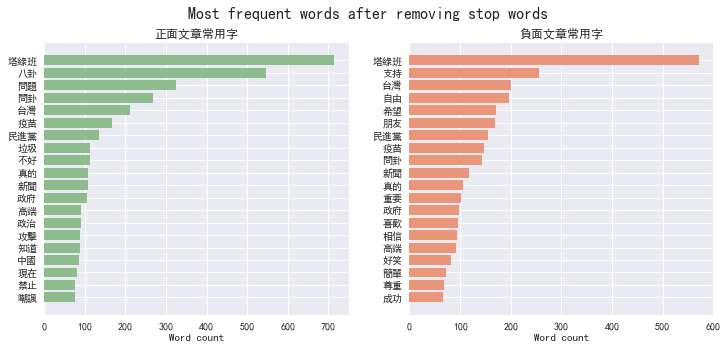

In [74]:
plt.figure(figsize=(12,5))   
plt.style.use('seaborn')    
plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文

plt.subplot(121)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(book1['word'],book1['size'],color="darkseagreen")

plt.subplot(122)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(book2['word'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)

plt.show()

### 2. 將資料切成訓練集與測試集
+ 根據7:3的比例切分資料集

In [75]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [76]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")

raw data percentage :
neu    80.468888
neg    10.377477
pos     9.153635
Name: label, dtype: float64

train percentage :
neu    80.469115
neg    10.378818
pos     9.152067
Name: label, dtype: float64

test percentage :
neu    80.468357
neg    10.374350
pos     9.157294
Name: label, dtype: float64


### 3. 將文章轉為 DTM
+ 3.1 簡單的例子示範
+ 3.2 套入正式的資料集

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)
    + ngram_range: unigrams and bigrams

### 3.1 簡單範例介紹DTM

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
     '塔綠斑 塔綠斑 塔綠斑',
     '民進黨 塔綠斑',
     '國民黨 民進黨 假新聞',
     '國民黨 民進黨',
]
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names()

# 轉成dataframe來看
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())

print(f"documents: {X.shape[0]} terms: {X.shape[1]}")
print(f"\nterms:\n {vocabulary}") # DTM 字詞可以藉由 get_feature_names 查看
print(f"\nDTM array:\n {X.toarray()}") # DTM的資料結構，裡面代表字詞的頻率
DTM_df

documents: 4 terms: 8

terms:
 ['假新聞', '國民黨', '國民黨 民進黨', '塔綠斑', '塔綠斑 塔綠斑', '民進黨', '民進黨 假新聞', '民進黨 塔綠斑']

DTM array:
 [[0 0 0 3 2 0 0 0]
 [0 0 0 1 0 1 0 1]
 [1 1 1 0 0 1 1 0]
 [0 1 1 0 0 1 0 0]]


,假新聞,國民黨,國民黨 民進黨,塔綠斑,塔綠斑 塔綠斑,民進黨,民進黨 假新聞,民進黨 塔綠斑
0,0,0,0,3,2,0,0,0
1,0,0,0,1,0,1,0,1
2,1,1,1,0,0,1,1,0
3,0,1,1,0,0,1,0,0


### 3.2 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [78]:
## 定義切分資料的 vectorizer
# Count (classic BoW) 
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2)) 
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2),min_df = 10)

# # Tf-Idf (advanced variant of BoW)
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100, ngram_range=(1,2))

In [79]:
corpus = dtf_train["clean_txt"]

+ 過濾詞頻比較

In [80]:
# 沒有過濾最低詞頻的 vectorizer
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 過濾至少要出現10次 vectorizer
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

In [81]:
print(f"without term cut off: posts {X_train.shape[0]} words: {X_train.shape[1]} ({len(vocabulary)})") 
print(f"with term cut off: posts {X_train_min.shape[0]} words: {X_train_min.shape[1]} ({len(vocabulary_min)})") 
X_train

without term cut off: posts 27797 words: 10000 (10000)
with term cut off: posts 27797 words: 1712 (1712)


<27797x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 88848 stored elements in Compressed Sparse Row format>

In [82]:
# 定義分類器模型
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [83]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/home/ann2/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.95
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.74      0.83      1236
         neu       0.95      1.00      0.97      9587
         pos       0.99      0.78      0.88      1091

    accuracy                           0.95     11914
   macro avg       0.97      0.84      0.89     11914
weighted avg       0.95      0.95      0.95     11914



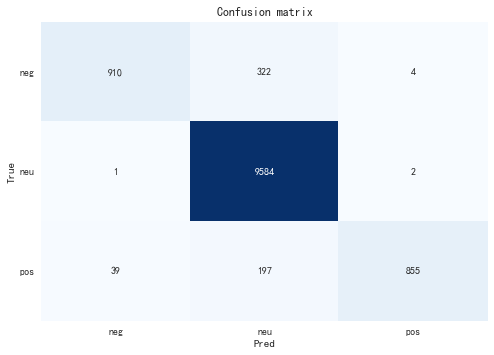

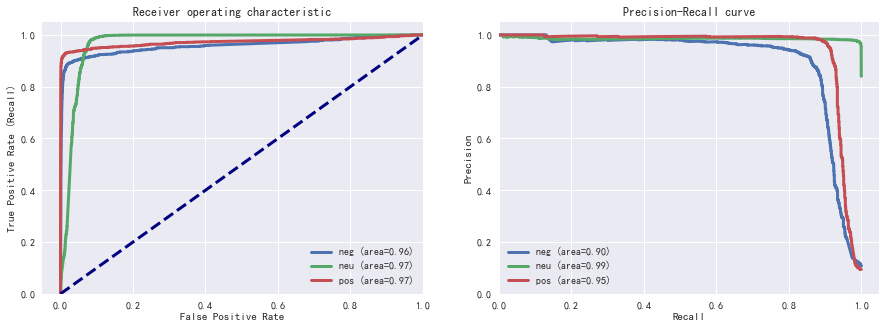

In [84]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### 4. 比較不同模型和資料組合的訓練結果
+ 資料集: 詞頻、tfidf 的 DTM
+ 比較標準: ROC, AUC, confusion matrix
+ 模型:
    + 4.1 logistic regression
    + 4.2 SVC
    + 4.3 decision tree
+ 4.4 預測結果探索

In [85]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [86]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

ROC 適用二元分類，故將每個類別的預測都視作為一個二元分類，以下比較上面各模型的分類效果

### step 1 定義 vectorizer

In [87]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2), min_df = cut_off) 
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df = cut_off)

### step 2 定義 classifier

In [88]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

### step 3 定義測試和訓練資料集

In [89]:
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [90]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

### 4.2.1 Model Building : logistic regression

logistic regression 原本是用來做二元分類的，如果要多元分類需要另外指定
+ 預設是預測二元分布(binomial probability)的機率，需要改為多元分布(multinomial probability)
+ 在這裡我們把線性模型存起來，做後續的係數分析
+ [參考: Multinomial Logistic Regression With Python](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/)

model type: CV + logistic regression


/home/ann2/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2
time costing: 3.4155476093292236
Accuracy: 0.95
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.74      0.83      1236
         neu       0.95      1.00      0.97      9587
         pos       0.99      0.78      0.88      1091

    accuracy                           0.95     11914
   macro avg       0.97      0.84      0.89     11914
weighted avg       0.95      0.95      0.95     11914



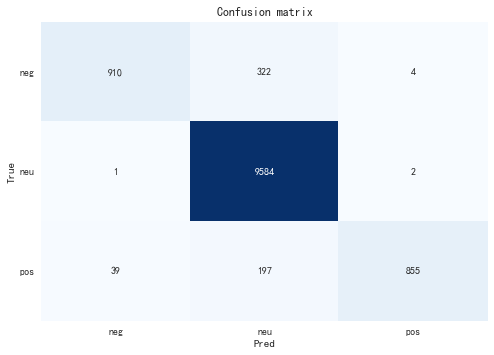

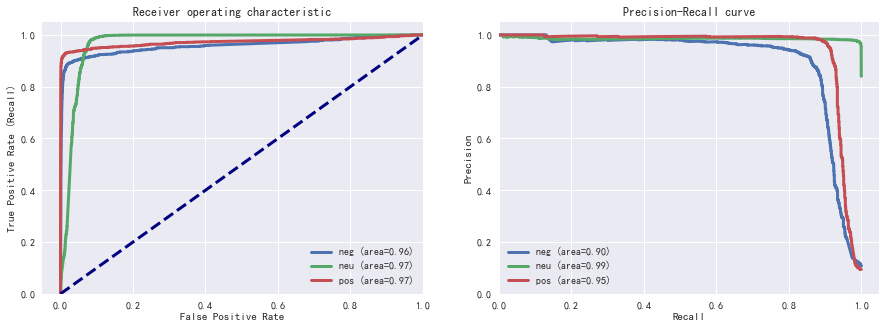

In [91]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression


/home/ann2/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2
time costing: 2.792374849319458
Accuracy: 0.92
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.57      0.71      1236
         neu       0.91      1.00      0.95      9587
         pos       1.00      0.62      0.76      1091

    accuracy                           0.92     11914
   macro avg       0.95      0.73      0.81     11914
weighted avg       0.92      0.92      0.91     11914



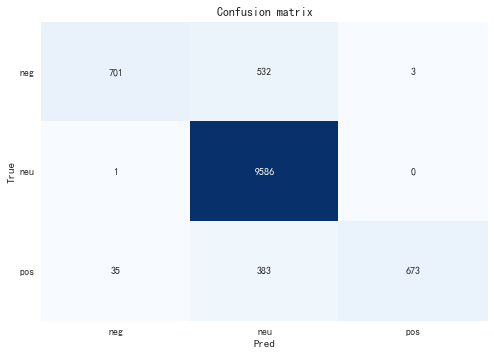

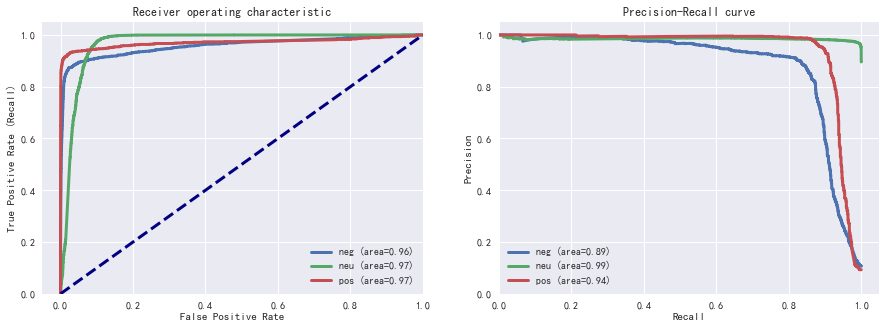

In [92]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 4.2.2 Model Building : SVC

model type: CV + SVC
2
time costing: 386.6143889427185
Accuracy: 0.91
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.49      0.65      1236
         neu       0.90      1.00      0.95      9587
         pos       1.00      0.55      0.71      1091

    accuracy                           0.91     11914
   macro avg       0.95      0.68      0.77     11914
weighted avg       0.91      0.91      0.89     11914



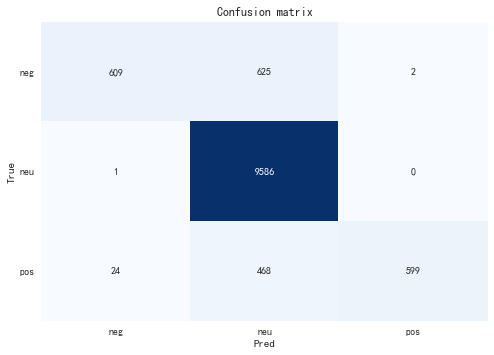

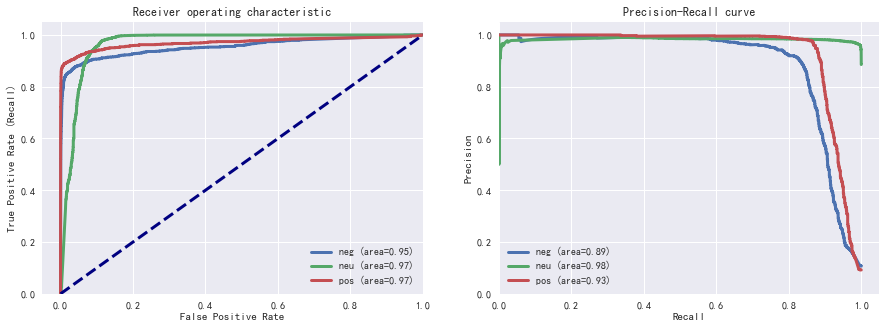

In [93]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
2
time costing: 452.7174229621887
Accuracy: 0.93
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.60      0.74      1236
         neu       0.92      1.00      0.96      9587
         pos       0.99      0.66      0.79      1091

    accuracy                           0.93     11914
   macro avg       0.96      0.75      0.83     11914
weighted avg       0.93      0.93      0.92     11914



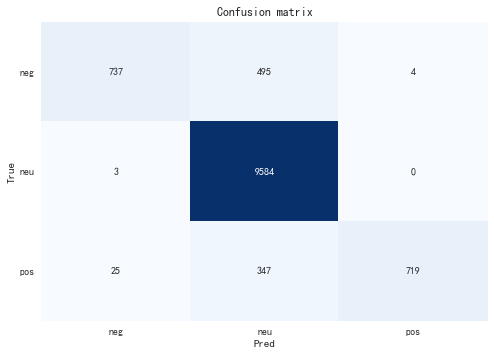

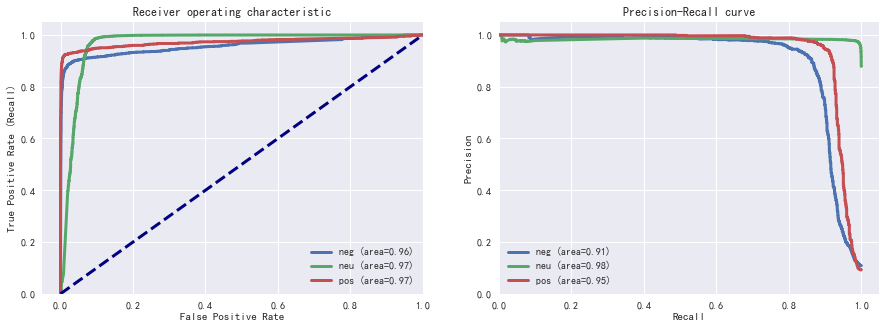

In [94]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 4.2.3 Model Building : RandomForest

model type: CV + RandomForest
2
time costing: 21.03435182571411
Accuracy: 0.97
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.87      0.91      1236
         neu       0.98      1.00      0.99      9587
         pos       0.98      0.90      0.94      1091

    accuracy                           0.97     11914
   macro avg       0.97      0.92      0.94     11914
weighted avg       0.97      0.97      0.97     11914



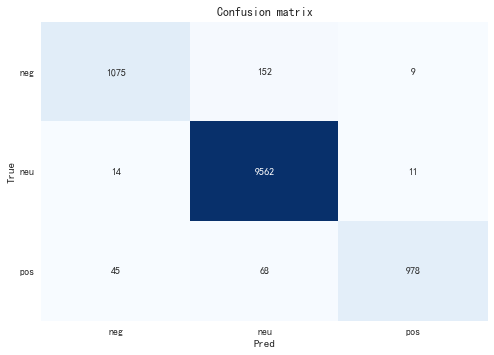

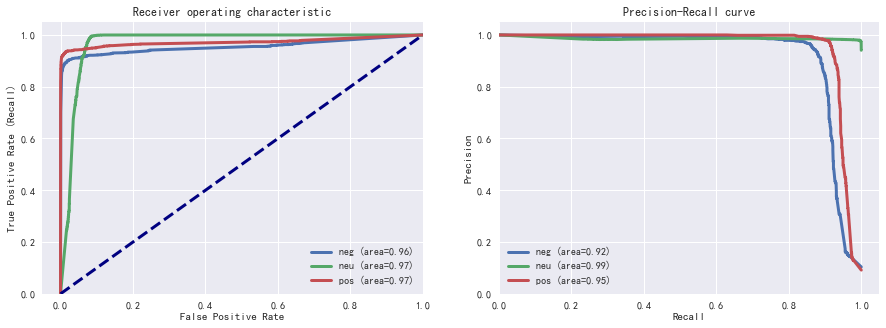

In [95]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
2
time costing: 20.13724374771118
Accuracy: 0.97
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.86      0.90      1236
         neu       0.98      1.00      0.99      9587
         pos       0.98      0.88      0.93      1091

    accuracy                           0.97     11914
   macro avg       0.97      0.91      0.94     11914
weighted avg       0.97      0.97      0.97     11914



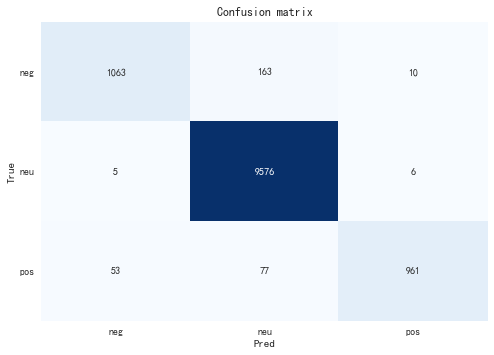

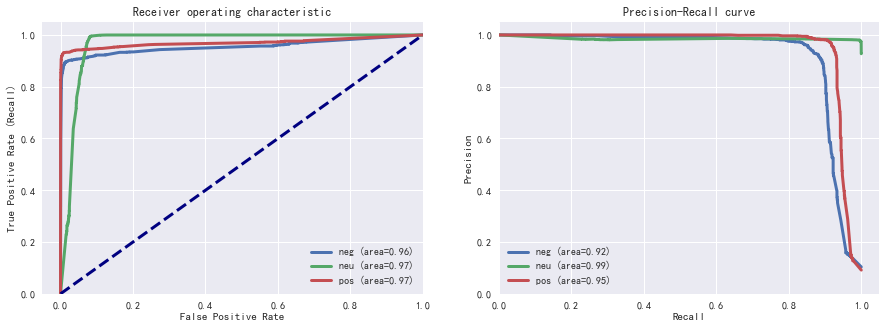

In [96]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 4.4 預測結果探索
+ 4.4.1 各字詞特徵的estimate係數
+ 4.4.2 查看分類錯誤的句子
+ 4.4.3 比較不同模型的ROC

+ 查看模型預測結果

In [97]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
4,CV + RandomForest,0.974903,0.965419
5,TF-IDF + RandomForest,0.973644,0.964343
0,CV + logistic regression,0.952577,0.966694
3,TF-IDF + SVC,0.926641,0.965441
1,TF-IDF + logistic regression,0.919926,0.965211
2,CV + SVC,0.905993,0.963322


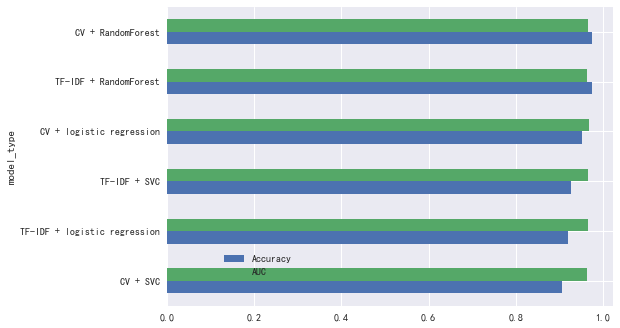

In [98]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(0.3,0.2))

可以看到效果最好得組合是tf-idf，加上隨機森林的模型

### 4.4.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate代表特徵每增加一單位，y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉 4.2.1 的 logistic regression + cv tokenizer 為例

In [99]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 5)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [100]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 4-2-1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(5)

,neg,neu,pos
一一,-0.069979,-0.125582,-0.069916
一下,-0.037769,-0.146510,-0.044120
一下 中國,-0.086738,-0.032852,0.092094
一下 在野,-0.041047,0.620665,-0.082065
一下 塔綠班,-0.082065,-0.111797,0.290917


/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


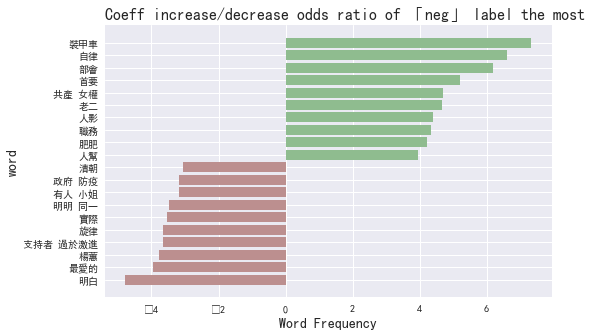

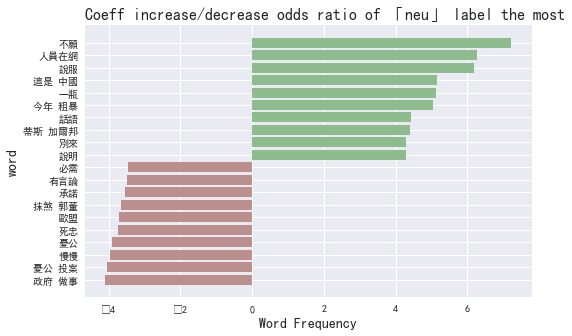

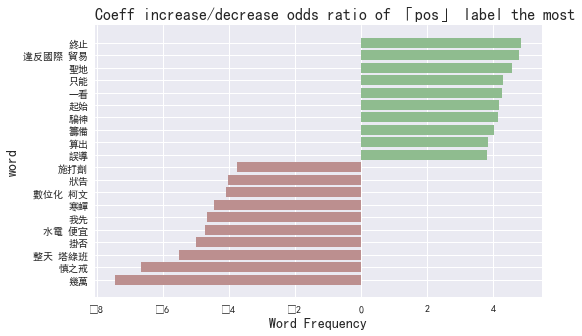

In [101]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

「八卦」、「問題」、「不好」 等字是影響判斷為負面情緒的重要字；「容易」、「支持」、「希望」等字是影響判斷為正面句子的重要字詞

### 看一下含特定關鍵字的句子

In [102]:
keyword_list = ['新試劑','殘劑']
data_senti[data_senti['sentence'].str.contains('|'.join(keyword_list),regex=True)][['document','sentence','artUrl','label']] \
                                .head(5)

,document,sentence,artUrl,label
62,62,新試劑服英戰士,https://www.ptt.cc/bbs/Gossiping/M.1630427949....,neu
239,239,新試劑扶英戰士,https://www.ptt.cc/bbs/Gossiping/M.1630457452....,neu
320,320,戰士》Kuso成「EUA新試劑扶英戰士」惡搞蔡英文政府，還把該動畫主題曲改編成「殘劑天,https://www.ptt.cc/bbs/Gossiping/M.1630460326....,neu
322,322,歌詞中譯後提到「像是殘劑的天使一樣，小英啊~變成神話吧」、「在肩上有著迎向,https://www.ptt.cc/bbs/Gossiping/M.1630460326....,neu
326,326,ーゼ）改編翻譯推出「殘劑天使」歌曲，最後還有人幫忙翻唱，引發網友熱烈討論，紛紛留,https://www.ptt.cc/bbs/Gossiping/M.1630460326....,pos


### 4.4.2 查看分類錯誤的句子

In [103]:
# 把預測的值加回去
dtf_test['predict'] = pred
pos_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'pos')] # 正面句子分錯
neg_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neg')] # 負面句子分錯
neu_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neu')] # 中性句子分錯

print(f"pos label predicted wrong: {pos_wrong.shape[0]}")
print(f"neg label predicted wrong: {neg_wrong.shape[0]}")
print(f"neu label predicted wrong: {neu_wrong.shape[0]}")

pos label predicted wrong: 130
neg label predicted wrong: 173
neu label predicted wrong: 11


/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


看一下都是什麼樣的句子分錯

In [104]:
# 正面句子分錯
pos_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
8068,醫院接受住院治療。,https://www.ptt.cc/bbs/Gossiping/M.1631076039....,pos,neu
5743,就足夠支撐整個社會的經濟運轉順暢,https://www.ptt.cc/bbs/Gossiping/M.1630859546....,pos,neu
12515,【改革單項協會壟斷】《國體法》三讀 小英：別懷疑政府的決心,https://www.ptt.cc/bbs/Gossiping/M.1631501187....,pos,neg
31772,但反而中山碩士焦糖品格更高、變相值得稱讚的八卦？,https://www.ptt.cc/bbs/Gossiping/M.1632239265....,pos,neg
11837,所有的單位若能在原單位開會，效率就會比較高，但EOC防疫防颱的通訊系統要先設置好，確診不會斷...,https://www.ptt.cc/bbs/Gossiping/M.1631456089....,pos,neu


In [105]:
# 負面句子分錯
neg_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
1285,該不會這麼悲觀」。,https://www.ptt.cc/bbs/Gossiping/M.1630532431....,neg,neu
37685,我是強烈建議啦！,https://www.ptt.cc/bbs/Gossiping/M.1632465148....,neg,neu
6614,這些新聞、預算支配網路都可以查的到,https://www.ptt.cc/bbs/Gossiping/M.1630931916....,neg,neu
28011,美國，歧視黑人的言論會受到制裁；在德國，支持納粹的言論也會受到懲罰；在台灣，公,https://www.ptt.cc/bbs/Gossiping/M.1632198062....,neg,pos
17145,你開的條件如果符合iPhone 例如:用很久 持續更新不當孤兒 打遊戲(這也有可能推ROG等),https://www.ptt.cc/bbs/Gossiping/M.1631849501....,neg,neu


In [106]:
# 中性句子分錯
neu_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
12365,反而覺得人生充滿樂趣。,https://www.ptt.cc/bbs/Gossiping/M.1631496130....,neu,neg
35306,前瞻這麼多錢跑到哪里,https://www.ptt.cc/bbs/Gossiping/M.1632374336....,neu,pos
15747,收到這麼高的稅要幹嘛?,https://www.ptt.cc/bbs/Gossiping/M.1631781616....,neu,pos
31635,上ptt把推塔綠班的帳號都標記起來。,https://www.ptt.cc/bbs/Gossiping/M.1632235440....,neu,pos
27793,我484應該對於我的認知乏弱感到愧疚,https://www.ptt.cc/bbs/Gossiping/M.1632197254....,neu,neg


觀察模型分類效果，若一開始標註情況不佳，可以依據分類結果修改情緒字典

### 4.4.3 比較不同模型的ROC

ROC 只適用二元分類，故將每個類別的預測都視作為一個二元分類，以下比較上面各模型的分類效果

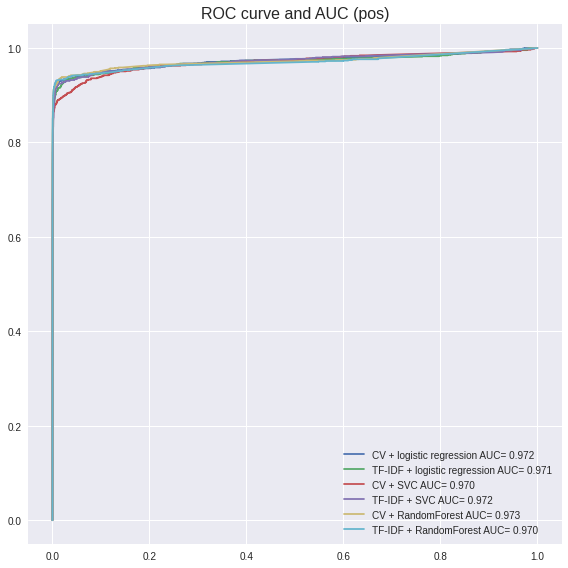

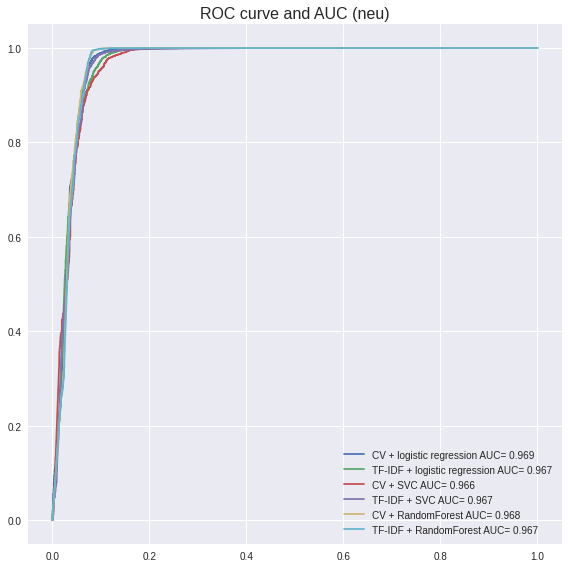

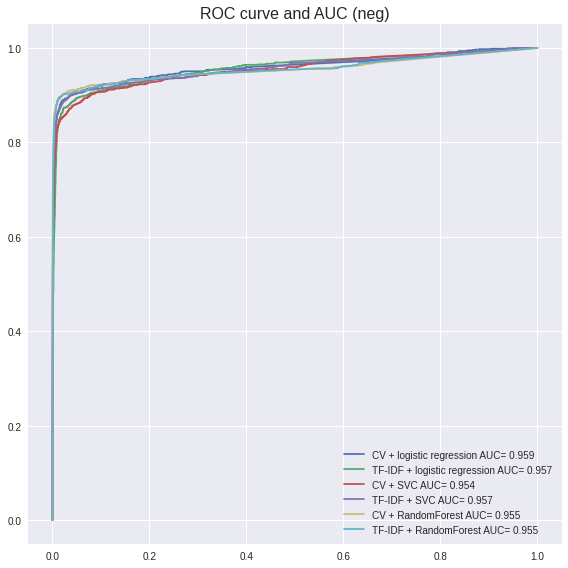

In [107]:
plt.style.use('seaborn')    

l = ['pos','neu','neg']
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ label +')', size = 16)    
    plt.legend(loc=0)
    plt.tight_layout()

accuracy可能會因為正負面資料分布不同而有所偏差，所以選擇模型的時候，可以加入一起 AUC 評估。在這裡可以看到個模型在三種情緒的AUC指標都不會相差太多，整體而言除了正面情緒 CV + logistic 外，TF-IDF + SVC 的表現較好。